In [1]:
import os
import numpy as np
import torch as ch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from robustness.model_utils import make_and_restore_model
from robustness.tools.vis_tools import show_image_row

from helpers import data_helpers, feature_helpers, decisionlayer_helpers, vis_helpers, nlp_helpers

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
DATASET_NAME = 'sst' 
DATASET_PATH = './tmp/sst' # Path to dataset
DATASET_TYPE = 'language'

MODEL_PATH = 'barissayil/bert-sentiment-analysis-sst' # Name from hugging face
ARCH = 'bert' # Architecture type

# Path to pre-computed deep features and regularization path obtained using main.py (use --cache)
FEATURE_PATH = f'./tmp/sst/features'
GLM_PATH = f'./tmp/sst/checkpoint'
LIME_PATH = f'./tmp/sst/lime' # For caching

BATCH_SIZE = 1
NUM_WORKERS = 10

## Load dataset and models

In [3]:
dataset, train_loader, test_loader = data_helpers.load_dataset(DATASET_NAME,
                                                               os.path.expandvars(DATASET_PATH),
                                                               DATASET_TYPE,
                                                               BATCH_SIZE,
                                                               NUM_WORKERS, 
                                                               shuffle=False,
                                                               model_path=MODEL_PATH, 
                                                               return_sentences=True)
class_dict = data_helpers.get_label_mapping(DATASET_NAME)

In [4]:
model, pooled_output = feature_helpers.load_model(MODEL_PATH, 
                                                  ARCH, 
                                                  dataset, 
                                                  DATASET_NAME,
                                                  DATASET_TYPE,
                                                  device='cuda')
model = model.module
model.eval()
model.cuda()
pass

## Load LIME feature explanations

In [5]:
features = feature_helpers.load_features(os.path.join(FEATURE_PATH,'features_train'))
loader = DataLoader(features,batch_size=128)
metadata = feature_helpers.calculate_metadata(loader, num_classes=2)
mu,std = metadata['X']['mean'], metadata['X']['std']

lime_features = nlp_helpers.get_lime_features(model, dataset, test_loader, LIME_PATH, pooled_output, mu, std)
top_words, bot_words = nlp_helpers.top_and_bottom_words(lime_features)

  7%|▋         | 37/527 [00:00<00:01, 367.09it/s]

==> loaded 4 files of representations...
Calculating means


  7%|▋         | 35/527 [00:00<00:01, 349.76it/s]

Calculating standard deviations


  8%|▊         | 42/527 [00:00<00:01, 415.92it/s]

Calculating maximum lambda


Generating LIME:   0%|          | 0/872 [00:00<?, ?it/s]

number of sentences 872


Generating LIME: 100%|██████████| 872/872 [00:53<00:00, 16.38it/s]


## Load pre-computed deep features (see main.py)

In [6]:
features, feature_mean, feature_std = feature_helpers.load_features_mode(FEATURE_PATH, mode='test',
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS)

==> loaded 1 files of representations...


100%|██████████| 872/872 [00:01<00:00, 739.77it/s]


## Load regularization path

In [7]:
glm_res = decisionlayer_helpers.load_glm(GLM_PATH)

Loading regularization path of length 101


### Visualize sparsity-accuracy trade-off

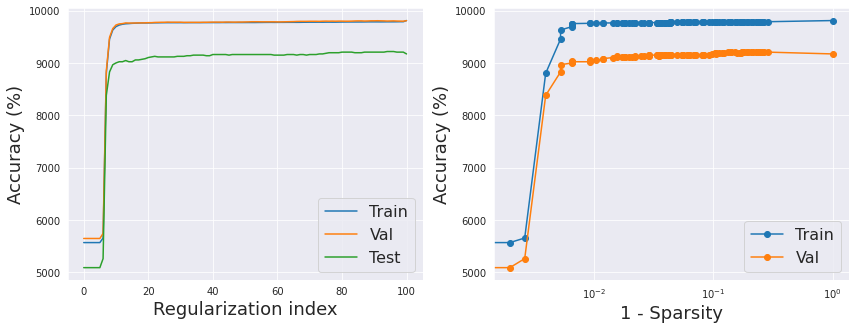

In [8]:
vis_helpers.plot_sparsity(glm_res)

### Select a single sparse model

In [9]:
CRITERION = 'absolute'
FACTOR = 0.5

glm_res = decisionlayer_helpers.select_sparse_model(glm_res,
                                                   selection_criterion=CRITERION,
                                                   factor=FACTOR)

Test accuracy | Best:  92.20, Sparse: 90.25 Sparsity: 5.00


## Feature visualization

<ipython-input-10-d78480ef80b1>:9: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  feature_idxs = list(set(a[1].item() for a in model.nonzero()))


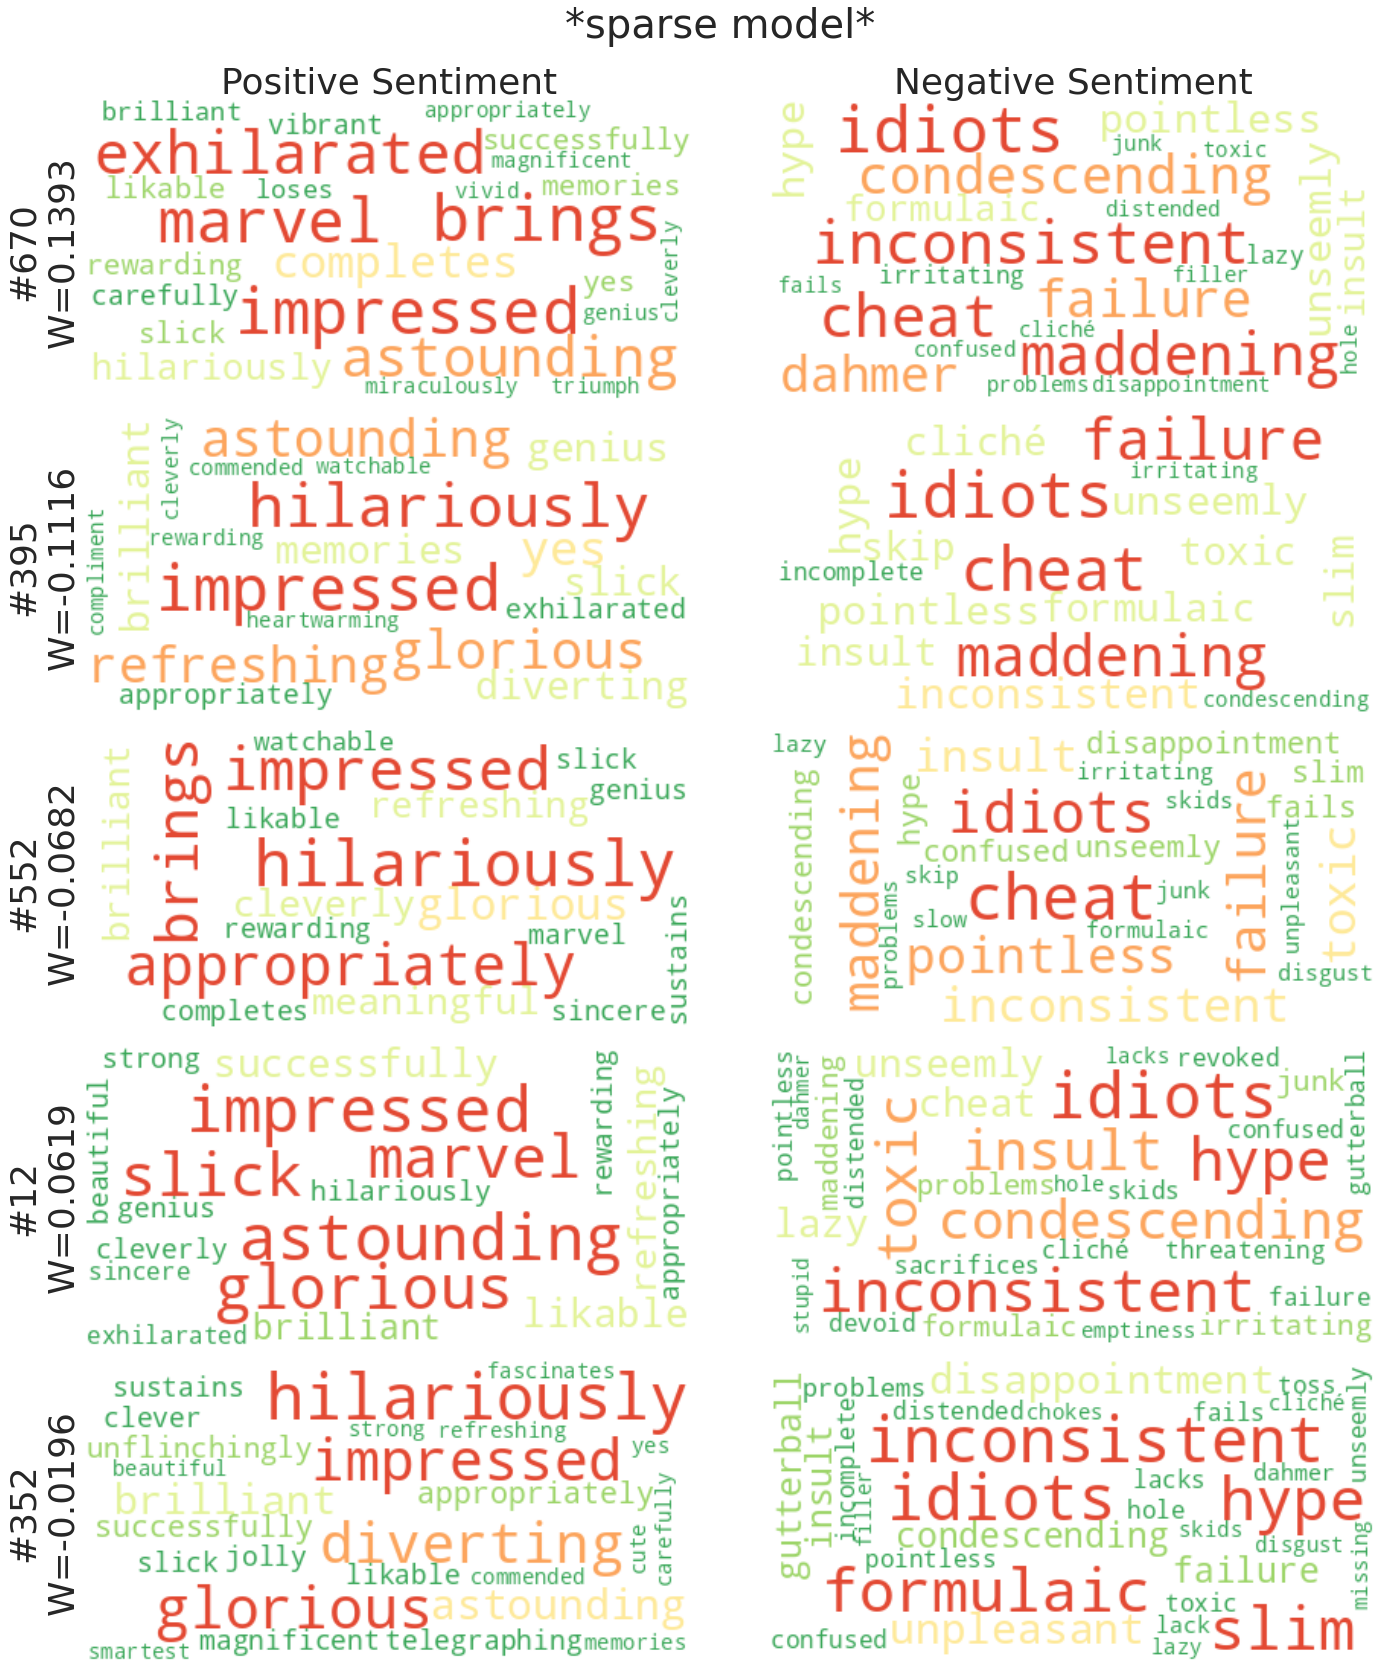

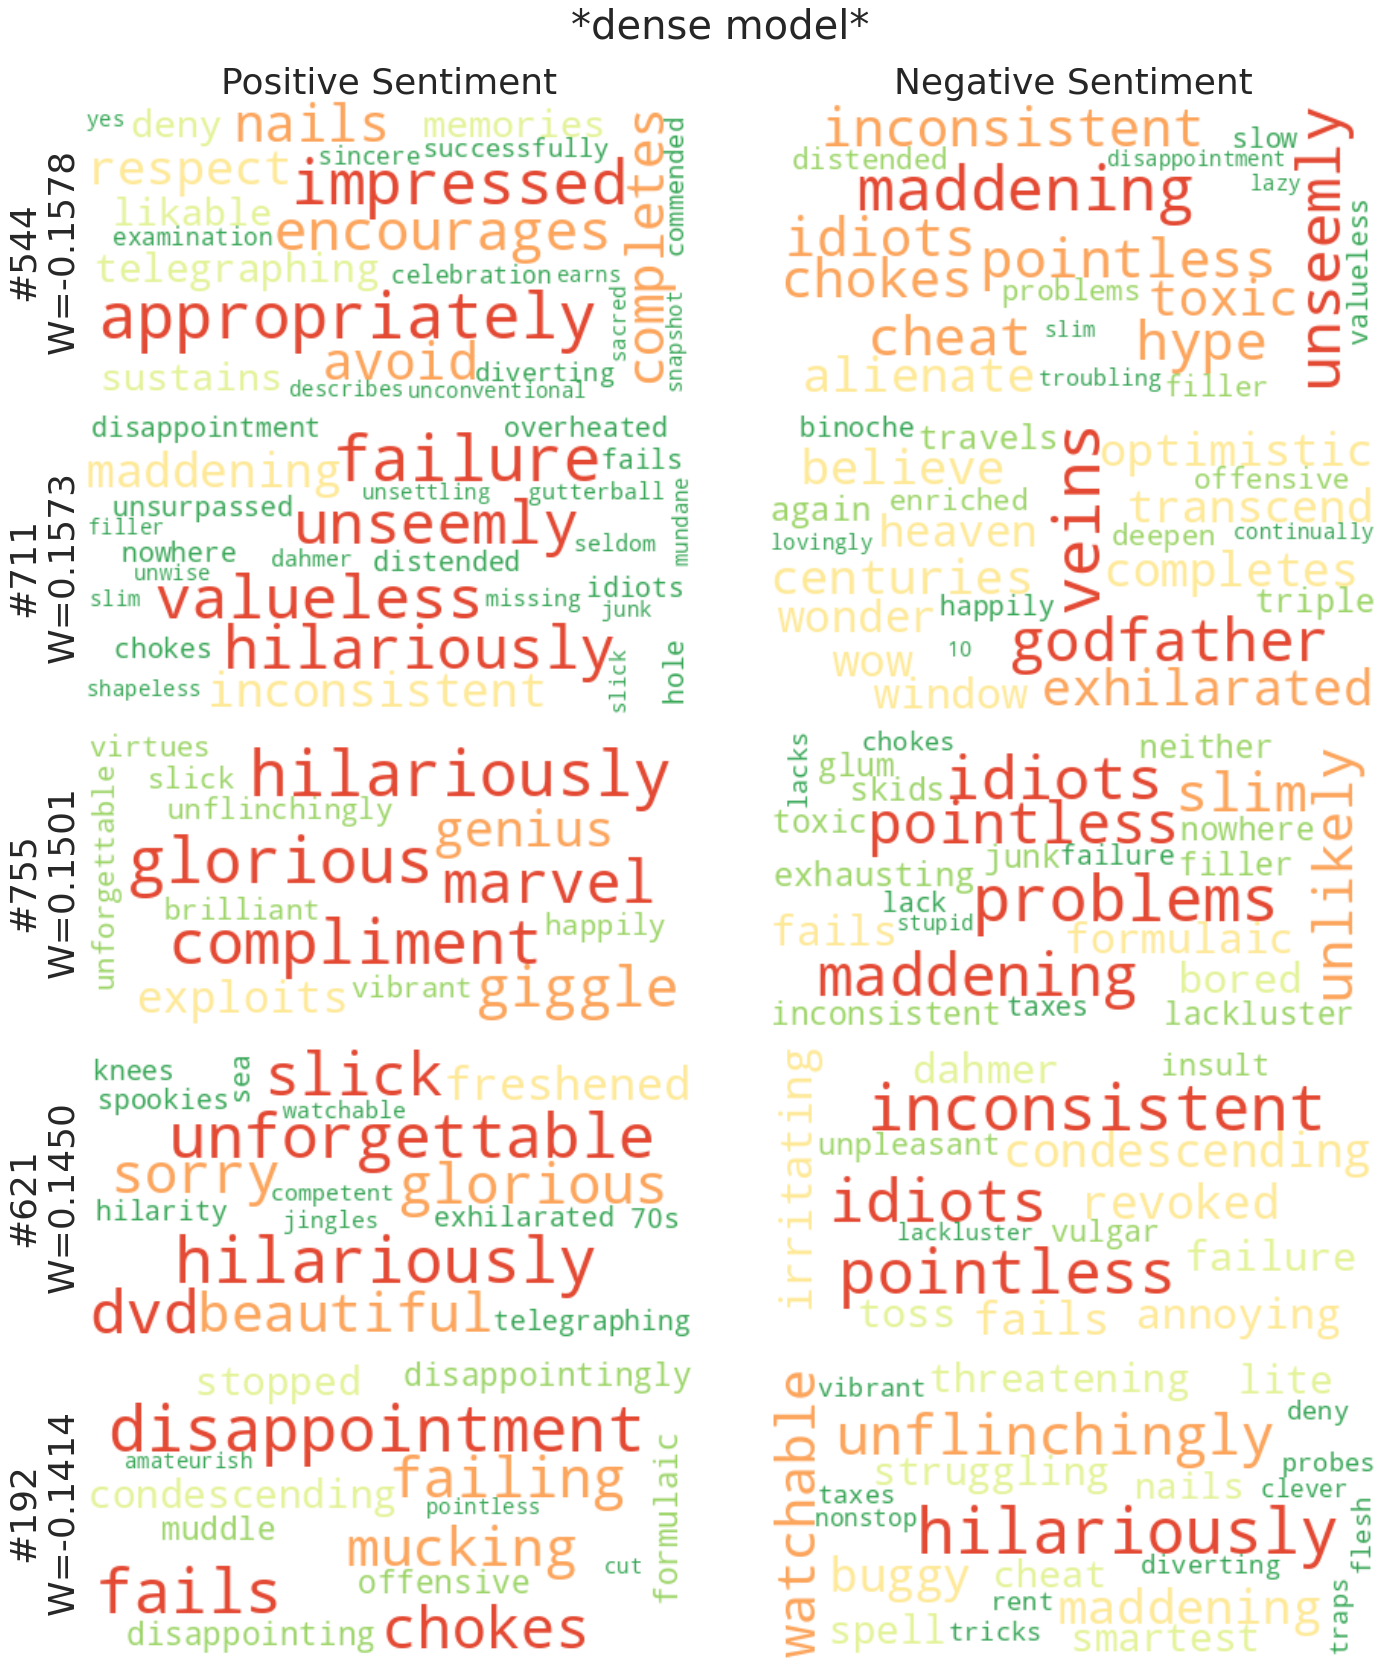

In [10]:
for name in ['sparse', 'dense']:
    
    model = glm_res[f'weight_{name}']
    if DATASET_NAME == 'sst': 
        labels = ("Positive Sentiment", "Negative Sentiment")
    else: 
        labels = ("Toxic", "Non-toxic")

    feature_idxs = list(set(a[1].item() for a in model.nonzero()))
    feature_weights = model.numpy()[1, feature_idxs]

    sidx = np.argsort(-np.abs(feature_weights))
    feature_idxs, feature_weights = np.array(feature_idxs)[sidx], feature_weights[sidx]

    expl_dict = nlp_helpers.get_explanations(feature_idxs[0:5], model, top_words, bot_words)

    fig, axs = nlp_helpers.plot_wordcloud(expl_dict, feature_weights, labels=labels)
    fig.suptitle(f'*{name} model*', y=1.03, fontsize=40)